In [112]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [113]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [114]:
activation_functions = {
    'tanh': tf.tanh,
    'relu': tf.nn.relu,
    'sigmoid': tf.nn.sigmoid,
    'linear': tf.keras.activations.linear,
    'softmax': tf.nn.softmax,
    'sign': tf.sign,
    'sin': tf.sin,
    'exp': tf.exp
}

**Loading Data**

In [115]:
SUBSET = 1.0    # subset (in percentage) of X_test used during training

In [116]:
%%time

# numpy
_, (X_test, y_test) = mnist.load_data() # only care  about X_test

selection = np.random.choice(np.arange(X_test.shape[0]),
                             int(SUBSET * X_test.shape[0]),
                             replace=False)

X_test = X_test.reshape(10000, 784).astype(np.float32)[selection] / 255.0   # flatten
y_test = to_categorical(y_test)[selection]  # one-hot encoding

# tensorflow
X_test = tf.convert_to_tensor(np.transpose(X_test))
y_test = tf.convert_to_tensor(np.transpose(y_test))

# for evaluation
y_true = np.argmax(y_test, axis=0)

CPU times: total: 266 ms
Wall time: 267 ms


**Network Definition**

In [117]:
MUTATE_RATE_MATRIX = 0.6559187146493448
MUTATE_RATE_BIAS = 0.8030669572606471
MUTATE_RATE_ACTIVATION_FUNCTION = 0.02218137574419697
CROSSOVER_RATE = 0.9448150239481161
GAUSSIAN_NOISE_STDDEV = 0.9280317826077495   # mutation applies additive gaussian noise
UNIFORM_CROSSOVER = False   # if True, performs crossover of matrices element-wise, else row-wise
HIDDEN_LAYER_WIDTH = 5     # TODO: for now all hidden layers same width

In [118]:
class MultiLayerPerceptron(Model):
    def __init__(self, **params):
        """
        Weight gnostic multi-layer feed forward neural network
        :param params: Params have to be in form: (matrix1=..., bias1=..., activations1=..., matrix2=..., ...)
        """
        super(MultiLayerPerceptron, self).__init__()

        self.n_layers = max([int(param_name[-1]) for param_name in params.keys()])   # = number of hidden layers + 1 (output layer)

        for (param_name, param) in params.items():
            assert param_name[:-1] in ('matrix', 'bias', 'activation'), 'Invalid attribute!'
            setattr(self, param_name, param)

    def call(self, inputs):
        x = inputs

        for layer in range(1, self.n_layers + 1):
            x = getattr(self, 'matrix' + str(layer)) @ x
            x += getattr(self, 'bias' + str(layer))
            x = activation_functions[getattr(self, 'activation' + str(layer))](x)

        return x

    def evaluate(self):
        y_pred = np.argmax(self.call(X_test), axis=0)
        return np.mean(y_pred == y_true)

    def mutate(self):
        for layer in range(1, self.n_layers + 1):
            # matrix
            matrix = getattr(self, 'matrix' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, 'matrix' + str(layer), matrix)

            # bias
            bias = getattr(self, 'bias' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[0]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, 'bias' + str(layer), bias)

            # activation
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))
            if random.uniform(0, 1) < MUTATE_RATE_ACTIVATION_FUNCTION:
                activation = random.choice(list(activation_functions.keys()))
            setattr(self, 'activation' + str(layer), activation)

    def summary(self):
        dash = '-' * 75
        ddash = '=' * 75
        print(dash)
        print('Model')
        print(ddash)

        n_params = 0
        for layer in range(1, self.n_layers + 1):
            # get values
            matrix = getattr(self, 'matrix' + str(layer))
            bias = getattr(self, 'bias' + str(layer))
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))

            n_params += matrix.shape[0] * matrix.shape[1] + bias.shape[0] * bias.shape[1] + 1

            # print adjustments
            activation = '({})'.format(activation)
            layer_IO = '(in={}, out={})'.format(matrix.shape[1], matrix.shape[0],)

            print('Linear {:<20}{:<30}#Params: {}'.format(activation, layer_IO, matrix.shape[0] * matrix.shape[1] + bias.shape[0] * bias.shape[1] + 1))

        print(ddash)
        print('Total params: {}'.format(n_params))
        print('Accuracy: {}\n'.format(round(self.evaluate(), 3)))

In [119]:
class Population:
    # TODO: n_layers evolvable
    def __init__(self, size=10, n_survivors=5, n_hidden_layers=1):
        """
        :param size: population size
        :param n_survivors: number of survivors after each generation (rest is killed and unable to pass on its genes)
        :param n_hidden_layers: number of hidden layers
        """
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.n_hidden_layers = n_hidden_layers
        self.elite = None
        self.fitness = None # cache fitness for increased speed
        self.fitness_generation = -1  # generation when fitness was evaluated

        # initialization (gaussian)
        # TODO: hidden layer width fixed for now
        self.organisms = []
        for _ in range(size):
            params = {}

            n_neurons_prev = 784
            n_neurons_curr = HIDDEN_LAYER_WIDTH
            for layer in range(1, self.n_hidden_layers + 2):
                if layer == self.n_hidden_layers + 1:
                    n_neurons_curr = 10  # output layer
                params['matrix' + str(layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[n_neurons_curr, n_neurons_prev])
                params['bias' + str(layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[n_neurons_curr, 1])
                params['activation' + str(layer)] = 'sigmoid'
                n_neurons_prev = HIDDEN_LAYER_WIDTH

            model = MultiLayerPerceptron(**params)
            self.organisms.append(model)

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate() for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        children = []
        while len(children) < int(CROSSOVER_RATE * (self.size - 1)):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            child_params = {}
            for layer in range(1, father.n_layers + 1):
                if UNIFORM_CROSSOVER:
                    # matrix - uniform crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    father_mask = tf.round(tf.random.uniform(father_matrix.shape))
                    mother_mask = - (father_mask - 1)

                    child_matrix = tf.multiply(father_mask, father_matrix) + tf.multiply(mother_mask, mother_matrix)
                    child_params['matrix' + str(layer)] = child_matrix
                else:
                    # matrix - row-wise (neuron-wise) crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    n_rows = father_matrix.shape[0]
                    father_mask = np.random.choice([True, False], size=n_rows)

                    child_matrix = tf.convert_to_tensor([father_matrix[row, :] if father_mask[row] \
                                                         else mother_matrix[row, :] for row in range(n_rows)])
                    child_params['matrix' + str(layer)] = child_matrix

                # bias - uniform crossover
                father_bias = getattr(father, 'bias' + str(layer))
                mother_bias = getattr(mother, 'bias' + str(layer))

                father_mask = tf.round(tf.random.uniform(father_bias.shape))
                mother_mask = - (father_mask - 1)

                child_bias = tf.multiply(father_mask, father_bias) + tf.multiply(mother_mask, mother_bias)
                child_params['bias' + str(layer)] = child_bias

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                father_activation = cleaner(getattr(father, 'activation' + str(layer)))
                mother_activation = cleaner(getattr(mother, 'activation' + str(layer)))

                child_activation = father_activation if (random.uniform(0, 1) < 0.5) else mother_activation
                child_params['activation' + str(layer)] = child_activation

            model = MultiLayerPerceptron(**child_params)
            children.append(model)

        # if CROSSOVER_RATE != 100% allow some individuals to pass on their genes without crossover
        while len(children) < (self.size - 1):
            [model] = random.sample(parents + [self.elite], k=1)  # sample without replacement

            child_params = {}
            for layer in range(1, model.n_layers + 1):
                # matrix
                child_params['matrix' + str(layer)] = getattr(model, 'matrix' + str(layer))

                # bias
                child_params['bias' + str(layer)] = getattr(model, 'bias' + str(layer))

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                child_params['activation' + str(layer)] = cleaner(getattr(model, 'activation' + str(layer)))

            model = MultiLayerPerceptron(**child_params)
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self, debug=False):
        if debug:
            time_debug = ''

            t_a = time.time()
            parents = self.selection()  # ~0.0005s
            t_b = time.time()
            time_debug += 'selection time: {}s - '.format(round(t_b - t_a, 4))

            t_a = time.time()
            children = self.crossover(parents)  # ~0.28s
            t_b = time.time()
            time_debug += 'crossover time: {}s - '.format(round(t_b - t_a, 4))

            t_a = time.time()
            self.mutate(children)  # ~0.15s#
            t_b = time.time()
            time_debug += 'mutation time: {}s - '.format(round(t_b - t_a, 4))

            print(time_debug)
        else:
            parents = self.selection()
            children = self.crossover(parents)
            self.mutate(children)

        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        # plot evolution
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

        # plot best performing final network
        organism_fitness = self.organism_fitness()
        elite_index = np.argmax(organism_fitness)
        self.organisms[elite_index].summary()

**Training**

In [120]:
# initialization
GENERATIONS = 10000
POPULATION_SIZE = 14
SURVIVORS = 2
N_HIDDEN_LAYERS = 0

Starting training
Gen 0 :   avg: 0.087  -  max: 0.122 (0.07s)
Gen 1 :   avg: 0.095  -  max: 0.150 (0.12s)
Gen 2 :   avg: 0.130  -  max: 0.185 (0.12s)
Gen 3 :   avg: 0.120  -  max: 0.185 (0.11s)
Gen 4 :   avg: 0.159  -  max: 0.202 (0.12s)
Gen 5 :   avg: 0.170  -  max: 0.217 (0.13s)
Gen 6 :   avg: 0.178  -  max: 0.224 (0.11s)
Gen 7 :   avg: 0.192  -  max: 0.228 (0.11s)
Gen 8 :   avg: 0.210  -  max: 0.234 (0.11s)
Gen 9 :   avg: 0.207  -  max: 0.245 (0.12s)
Gen 10 :   avg: 0.213  -  max: 0.250 (0.12s)
Gen 11 :   avg: 0.181  -  max: 0.250 (0.11s)
Gen 12 :   avg: 0.205  -  max: 0.250 (0.11s)
Gen 13 :   avg: 0.223  -  max: 0.250 (0.11s)
Gen 14 :   avg: 0.212  -  max: 0.250 (0.11s)
Gen 15 :   avg: 0.230  -  max: 0.263 (0.12s)
Gen 16 :   avg: 0.240  -  max: 0.263 (0.11s)
Gen 17 :   avg: 0.231  -  max: 0.263 (0.12s)
Gen 18 :   avg: 0.235  -  max: 0.263 (0.13s)
Gen 19 :   avg: 0.229  -  max: 0.264 (0.12s)
Gen 20 :   avg: 0.247  -  max: 0.266 (0.12s)
Gen 21 :   avg: 0.246  -  max: 0.274 (0.12s)
Ge

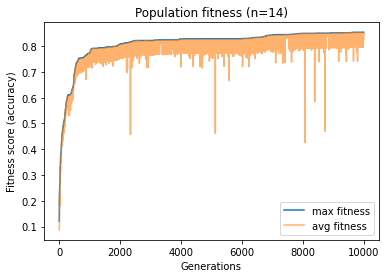

---------------------------------------------------------------------------
Model
Linear (sigmoid)           (in=784, out=10)              #Params: 7851
Total params: 7851
Accuracy: 0.854

CPU times: total: 18min 51s
Wall time: 18min 47s


In [121]:
%%time
# initial population
print('Starting training')
t_training = time.time()
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS, n_hidden_layers=N_HIDDEN_LAYERS)
avg_population_fitness = population.average_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen {} {:<3} avg: {:.3f} {:^3} max: {:.3f} ({:<3}s)'.format(
    0, ':', round(avg_population_fitness, 3), '-', round(max_fitness, 3), round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    avg_population_fitness = population.average_fitness()
    max_fitness = population.max_fitness()
    t2 = time.time()

    print('Gen {} {:<3} avg: {:.3f} {:^3} max: {:.3f} ({:<3}s)'.format(
        generation, ':', round(avg_population_fitness, 3), '-', round(max_fitness, 3), round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))

# performance of population
population.plot()

**Plot confusion matrix**

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 925,    0,    2,    8,    3,   12,   10,    1,   19,    0],
       [   2, 1092,    4,    7,    2,    2,    3,    1,   22,    0],
       [  10,   21,  861,   23,   30,    5,   13,   26,   29,   14],
       [   9,    5,   28,  848,    1,   46,    8,   11,   40,   14],
       [   8,    4,    1,    4,  849,    2,   19,   13,   15,   67],
       [  34,   34,   13,   39,   21,  658,   29,   13,   32,   19],
       [  26,    3,   16,    9,   21,   25,  827,    1,   28,    2],
       [  12,   28,   39,   15,   24,   10,    4,  849,   14,   33],
       [  20,   19,    4,   43,   13,   21,   20,   18,  793,   23],
       [  19,   10,    5,   16,   47,   16,    5,   37,   18,  836]])>

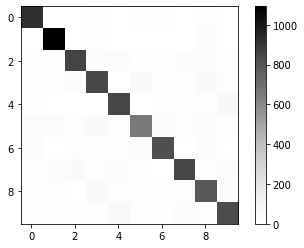

In [122]:
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(population.elite(X_test), axis=0))
plt.imshow(confusion_matrix, cmap='Greys')   # y-axis: y_true, x-axis: y_pred
plt.colorbar()
confusion_matrix

**Continue training with different params**

Gen 1 :   avg: 0.833  -  max: 0.839 (0.13s)
Gen 2 :   avg: 0.834  -  max: 0.839 (0.12s)
Gen 3 :   avg: 0.833  -  max: 0.839 (0.12s)
Gen 4 :   avg: 0.833  -  max: 0.839 (0.13s)
Gen 5 :   avg: 0.825  -  max: 0.839 (0.11s)
Gen 6 :   avg: 0.834  -  max: 0.839 (0.11s)
Gen 7 :   avg: 0.834  -  max: 0.839 (0.13s)
Gen 8 :   avg: 0.833  -  max: 0.839 (0.12s)
Gen 9 :   avg: 0.831  -  max: 0.839 (0.12s)
Gen 10 :   avg: 0.830  -  max: 0.839 (0.12s)
Gen 11 :   avg: 0.827  -  max: 0.839 (0.11s)
Gen 12 :   avg: 0.831  -  max: 0.839 (0.11s)
Gen 13 :   avg: 0.833  -  max: 0.839 (0.11s)
Gen 14 :   avg: 0.832  -  max: 0.839 (0.11s)
Gen 15 :   avg: 0.833  -  max: 0.839 (0.11s)
Gen 16 :   avg: 0.833  -  max: 0.839 (0.11s)
Gen 17 :   avg: 0.834  -  max: 0.839 (0.11s)
Gen 18 :   avg: 0.833  -  max: 0.839 (0.11s)
Gen 19 :   avg: 0.833  -  max: 0.839 (0.11s)
Gen 20 :   avg: 0.834  -  max: 0.839 (0.11s)
Gen 21 :   avg: 0.834  -  max: 0.839 (0.11s)
Gen 22 :   avg: 0.827  -  max: 0.839 (0.11s)
Gen 23 :   avg: 0.8

ValueError: x and y must have same first dimension, but have shapes (15659,) and (15658,)

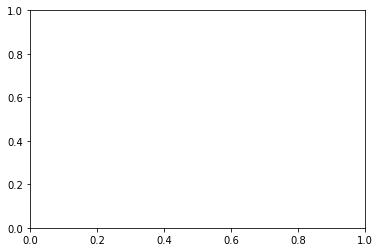

In [155]:
global MUTATE_RATE_MATRIX
global MUTATE_RATE_BIAS
global MUTATE_RATE_ACTIVATION_FUNCTION
global CROSSOVER_RATE
global GAUSSIAN_NOISE_STDDEV
global UNIFORM_CROSSOVER
global HIDDEN_LAYER_WIDTH

MUTATE_RATE_MATRIX = 0.6559187146493448
MUTATE_RATE_BIAS = 0.8030669572606471
MUTATE_RATE_ACTIVATION_FUNCTION = 0.02218137574419697
CROSSOVER_RATE = 0.9448150239481161
GAUSSIAN_NOISE_STDDEV = 0.9280317826077495   # mutation applies additive gaussian noise
UNIFORM_CROSSOVER = False   # if True, performs crossover of matrices element-wise, else row-wise
HIDDEN_LAYER_WIDTH = 5     # TODO: for now all hidden layers same width

for generation in range(1, 100):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    avg_population_fitness = population.average_fitness()
    max_fitness = population.max_fitness()

    t2 = time.time()
    print('Gen {} {:<3} avg: {:.3f} {:^3} max: {:.3f} ({:<3}s)'.format(
        generation, ':', round(avg_population_fitness, 3), '-', round(max_fitness, 3), round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))

# performance of population
population.plot()

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 919,    0,    6,   10,    3,   13,   11,    3,   13,    2],
       [   1, 1106,    1,    7,    1,    1,    3,    3,   12,    0],
       [  18,   22,  838,   23,   31,    3,   13,   35,   29,   20],
       [  11,    7,   26,  834,    2,   50,    7,   14,   42,   17],
       [   6,    2,    2,    3,  862,    1,   16,   10,    7,   73],
       [  41,   27,   18,   41,   43,  614,   29,   20,   36,   23],
       [  40,    5,   21,   12,   31,   12,  810,    2,   22,    3],
       [   5,   24,   30,   15,   29,    9,    5,  862,   13,   36],
       [  34,   29,    4,   49,   25,   16,   21,   24,  737,   35],
       [  13,   15,    4,   14,   88,   11,    4,   38,   14,  808]])>

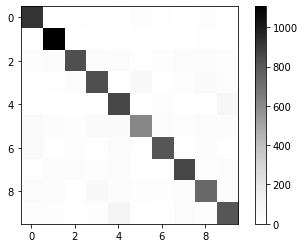

In [153]:
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(population.elite(X_test), axis=0))
plt.imshow(confusion_matrix, cmap='Greys')   # y-axis: y_true, x-axis: y_pred
plt.colorbar()
confusion_matrix